In [1]:
from fastai.vision import *

# DATA INSPECTION

In [2]:
classes = os.listdir("data/mountains")[1:]
print(classes)

['export.pkl', 'Strahlhorn', 'cleaned.csv', 'Grand_Combin', 'Matterhorn', 'Alphubel', 'Zinalrothorn', 'Dent_Blanche', 'Aletschhorn', 'Lyskamm', 'Finsteraarhorn', '.DS_Store', 'Dom', 'Breithorn', 'Monte_Rosa_(Dufourspitze)', "Dent_d'Hérens", 'models', 'Weisshorn']


## View/Load data

In [3]:
path = 'data/mountains'

In [4]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=32).normalize(imagenet_stats)
# if we don't have a trn, val, test set => passing 'train="."' says that the current folder contains the trn data,
# and 'valid_pct=0.2' will set aside randomely 20% of the data.

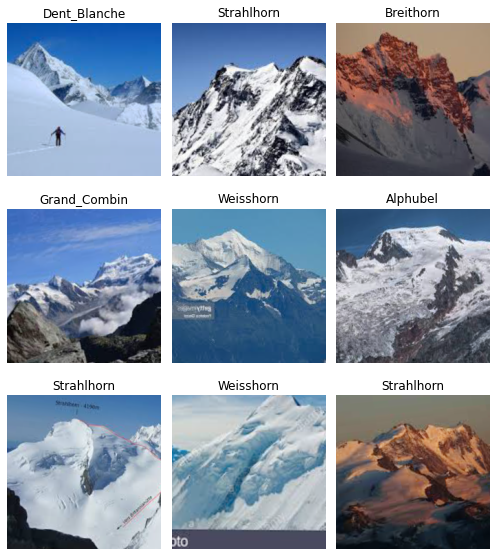

In [5]:
data.show_batch(rows=3, figsize=(7,8))

In [6]:
print("classes: ", data.classes)
print("nb classes: ", data.c)
print("nb training examples: ", len(data.train_ds))
print("nb val examples", len(data.valid_ds))

classes:  ['Aletschhorn', 'Alphubel', 'Breithorn', 'Dent_Blanche', "Dent_d'Hérens", 'Dom', 'Finsteraarhorn', 'Grand_Combin', 'Lyskamm', 'Matterhorn', 'Monte_Rosa_(Dufourspitze)', 'Rimpfischhorn', 'Strahlhorn', 'Weisshorn', 'Zinalrothorn']
nb classes:  15
nb training examples:  1869
nb val examples 467


# TRAINING

Create models folder and grant access if not already done

In [ ]:
#! sudo mkdir /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data/mountains/models
#! sudo chmod -R 777 /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data/mountains/models

Load a pre-trained imagenet RN-50 model and train on the mountains dataset.

In [7]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Load model trained on raw data for 40 epochs.

In [ ]:
learn.load("body-40-epochs");

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(4e-6,1e-3))

In [ ]:
learn.save("head-41-epochs")

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

In [ ]:
learn.save("head-42-epochs")

In [ ]:
learn.load("head-42-epochs");

In [ ]:
learn.unfreeze()

In [ ]:
learn.freeze()

## Interpretation

In [ ]:
learn.load('body-42-epochs');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused(min_val=2)

In [ ]:
interp.plot_top_losses(9, heatmap=True, figsize=(12,12))

## Cleaning Up

In [ ]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In [ ]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [ ]:
learn_cln = cnn_learner(db, models.resnet50, metrics=error_rate)

learn_cln.load('head-42-epochs');

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [ ]:
#losses,idxs = interp.top_losses(k=200)

In [ ]:
#! sudo chmod -R 777 /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data/mountains

In [ ]:
print(losses[:10])

In [ ]:
ImageCleaner(ds, idxs, path)

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Clean data

In [ ]:
df = pd.read_csv(path + '/cleaned.csv')
data_cln = ImageDataBunch.from_df(path, df=df, ds_tfms=get_transforms(), size=224, bs=32).normalize(imagenet_stats)

In [ ]:
data_cln.show_batch(rows=3, figsize=(7,8))

In [ ]:
learn_cln = cnn_learner(data_cln, models.resnet50, metrics=error_rate)

In [ ]:
learn_cln.load('head-42-epochs');

In [ ]:
learn_cln.lr_find()

In [ ]:
learn_cln.recorder.plot()

In [ ]:
learn_cln.fit_one_cycle(1, max_lr=slice(3e-4,1e-3))

In [ ]:
learn_cln.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

In [ ]:
learn_cln.unfreeze()

In [ ]:
learn_cln.lr_find()

In [ ]:
learn_cln.recorder.plot()

In [ ]:
learn_cln.fit_one_cycle(1, max_lr=slice(4e-5,2e-4))

In [ ]:
learn_cln.save("body-46-epochs-cln")

In [ ]:
learn_cln.freeze()

## Interpretation

In [8]:
learn_cln = cnn_learner(data, models.resnet50, metrics=error_rate)

In [9]:
learn_cln.load("body-46-epochs-cln");

In [10]:
interp = ClassificationInterpretation.from_learner(learn_cln)

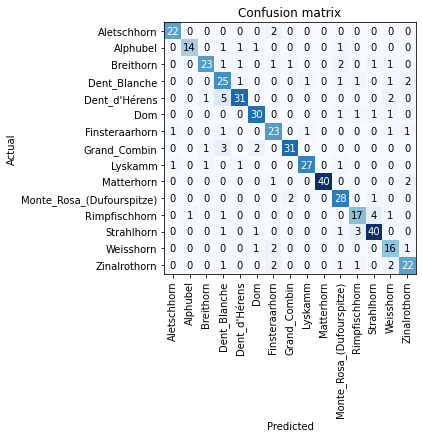

In [22]:
interp.plot_confusion_matrix(figsize=(6,6))
plt.savefig("data/confusion_matrix.pdf")

In [12]:
interp.most_confused(min_val=2)

[("Dent_d'Hérens", 'Dent_Blanche', 5),
 ('Rimpfischhorn', 'Strahlhorn', 4),
 ('Grand_Combin', 'Dent_Blanche', 3),
 ('Strahlhorn', 'Rimpfischhorn', 3),
 ('Aletschhorn', 'Finsteraarhorn', 2),
 ('Breithorn', 'Monte_Rosa_(Dufourspitze)', 2),
 ('Dent_Blanche', 'Zinalrothorn', 2),
 ("Dent_d'Hérens", 'Weisshorn', 2),
 ('Grand_Combin', 'Dom', 2),
 ('Matterhorn', 'Zinalrothorn', 2),
 ('Monte_Rosa_(Dufourspitze)', 'Grand_Combin', 2),
 ('Weisshorn', 'Finsteraarhorn', 2),
 ('Zinalrothorn', 'Finsteraarhorn', 2),
 ('Zinalrothorn', 'Weisshorn', 2)]

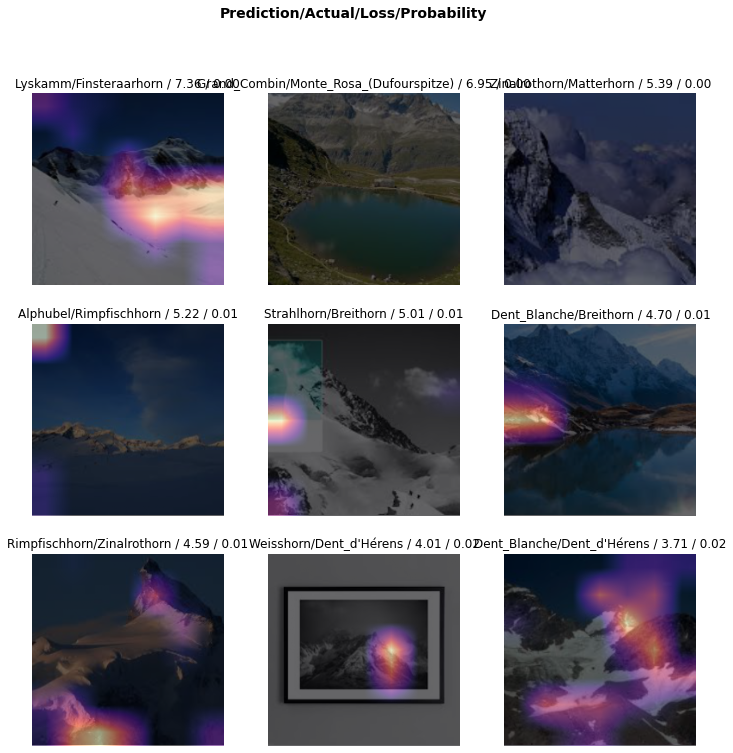

In [13]:
interp.plot_top_losses(9, heatmap=True, figsize=(12,12))

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [ ]:
learn_cln.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [14]:
defaults.device = torch.device('cpu')
print(defaults.device)

cpu


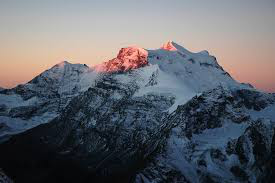

In [15]:
img = open_image(path+'/Grand_Combin'+'/00000038.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [16]:
learn = load_learner(path)

In [20]:
pred_class,pred_idx,outputs = learn.predict(img)
print("prediction: ", pred_class.obj)
print("probabilities:", sorted(
            zip(learn.data.classes, map(float, outputs)),
            key=lambda p: p[1],
            reverse=True
        ))

prediction:  Grand_Combin
probabilities: [('Grand_Combin', 0.574520468711853), ('Breithorn', 0.23486410081386566), ("Dent_d'Hérens", 0.03225356340408325), ('Rimpfischhorn', 0.02741577848792076), ('Matterhorn', 0.02602382004261017), ('Monte_Rosa_(Dufourspitze)', 0.02484705112874508), ('Zinalrothorn', 0.02346535585820675), ('Aletschhorn', 0.018009956926107407), ('Strahlhorn', 0.00919382181018591), ('Dom', 0.007154448889195919), ('Alphubel', 0.0067961555905640125), ('Weisshorn', 0.005752125754952431), ('Dent_Blanche', 0.005157387349754572), ('Lyskamm', 0.0026644172612577677), ('Finsteraarhorn', 0.0018815454095602036)]
